In [6]:
import numpy as np
import pandas as pd
import sys
import os
import pickle
import warnings
import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# SKLEARN IMPORTS
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")
%matplotlib inline

# --- CONFIGURATION ---
DATA_PATH = "Crop and fertilizer dataset.csv" # Ensure this file exists
OUTPUT_FILENAME = "fertilizer_recommendation_pipeline.pkl"
TARGET_COL = 'Fertilizer'
RANDOM_SEED = 42

print("All standard libraries and configuration loaded.")

All standard libraries and configuration loaded.


In [7]:
# --- 1. Import *CORRECTED* Custom Classifiers ---
# ❗ **ACTION REQUIRED**: Update CLASSIFIER_DIR to the path containing your custom classifier files.
CLASSIFIER_DIR = './' 

if CLASSIFIER_DIR not in sys.path:
    sys.path.append(os.path.abspath(CLASSIFIER_DIR))

try:
    # These MUST be the _FIXED versions you renamed
    from RandomForest import RandomForestClassifier
    from MultiLayerPerceptron import SimpleMLP
    print("Custom classifiers imported successfully.")
except ImportError as e:
    print(f"❌ ERROR: Could not import custom classifiers: {e}")
    print("Please ensure RandomForest.py and MultiLayerPerceptron.py are in the correct path.")
    # Note: We won't exit here, but model training will fail if classes aren't found.
except Exception as e:
    print(f"❌ ERROR: A problem occurred in the custom classifier files: {e}")

Custom classifiers imported successfully.


In [8]:
# --- 2. Load Dataset ---
print("\n--- 2. Loading Dataset ---")
try:
    df_raw = pd.read_csv(DATA_PATH)
    print(f"✅ Dataset loaded successfully. Shape: {df_raw.shape}")
    print(f"Columns: {list(df_raw.columns)}")
    print(f"\nFirst few rows:")
    print(df_raw.head())
    print(f"\nDataset Info:")
    print(df_raw.info())
except FileNotFoundError:
    print(f"❌ ERROR: File '{DATA_PATH}' not found. Please check the path.")
    df_raw = None
except Exception as e:
    print(f"❌ ERROR loading dataset: {e}")
    df_raw = None


--- 2. Loading Dataset ---
✅ Dataset loaded successfully. Shape: (4513, 11)
Columns: ['District_Name', 'Soil_color', 'Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature', 'Crop', 'Fertilizer', 'Link']

First few rows:
  District_Name Soil_color  Nitrogen  Phosphorus  Potassium   pH  Rainfall  \
0      Kolhapur      Black        75          50        100  6.5      1000   
1      Kolhapur      Black        80          50        100  6.5      1000   
2      Kolhapur      Black        85          50        100  6.5      1000   
3      Kolhapur      Black        90          50        100  6.5      1000   
4      Kolhapur      Black        95          50        100  6.5      1000   

   Temperature       Crop Fertilizer                          Link  
0           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
1           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
2           20  Sugarcane       Urea  https://youtu.be/2t5Am0xLTOo  
3           20  Su

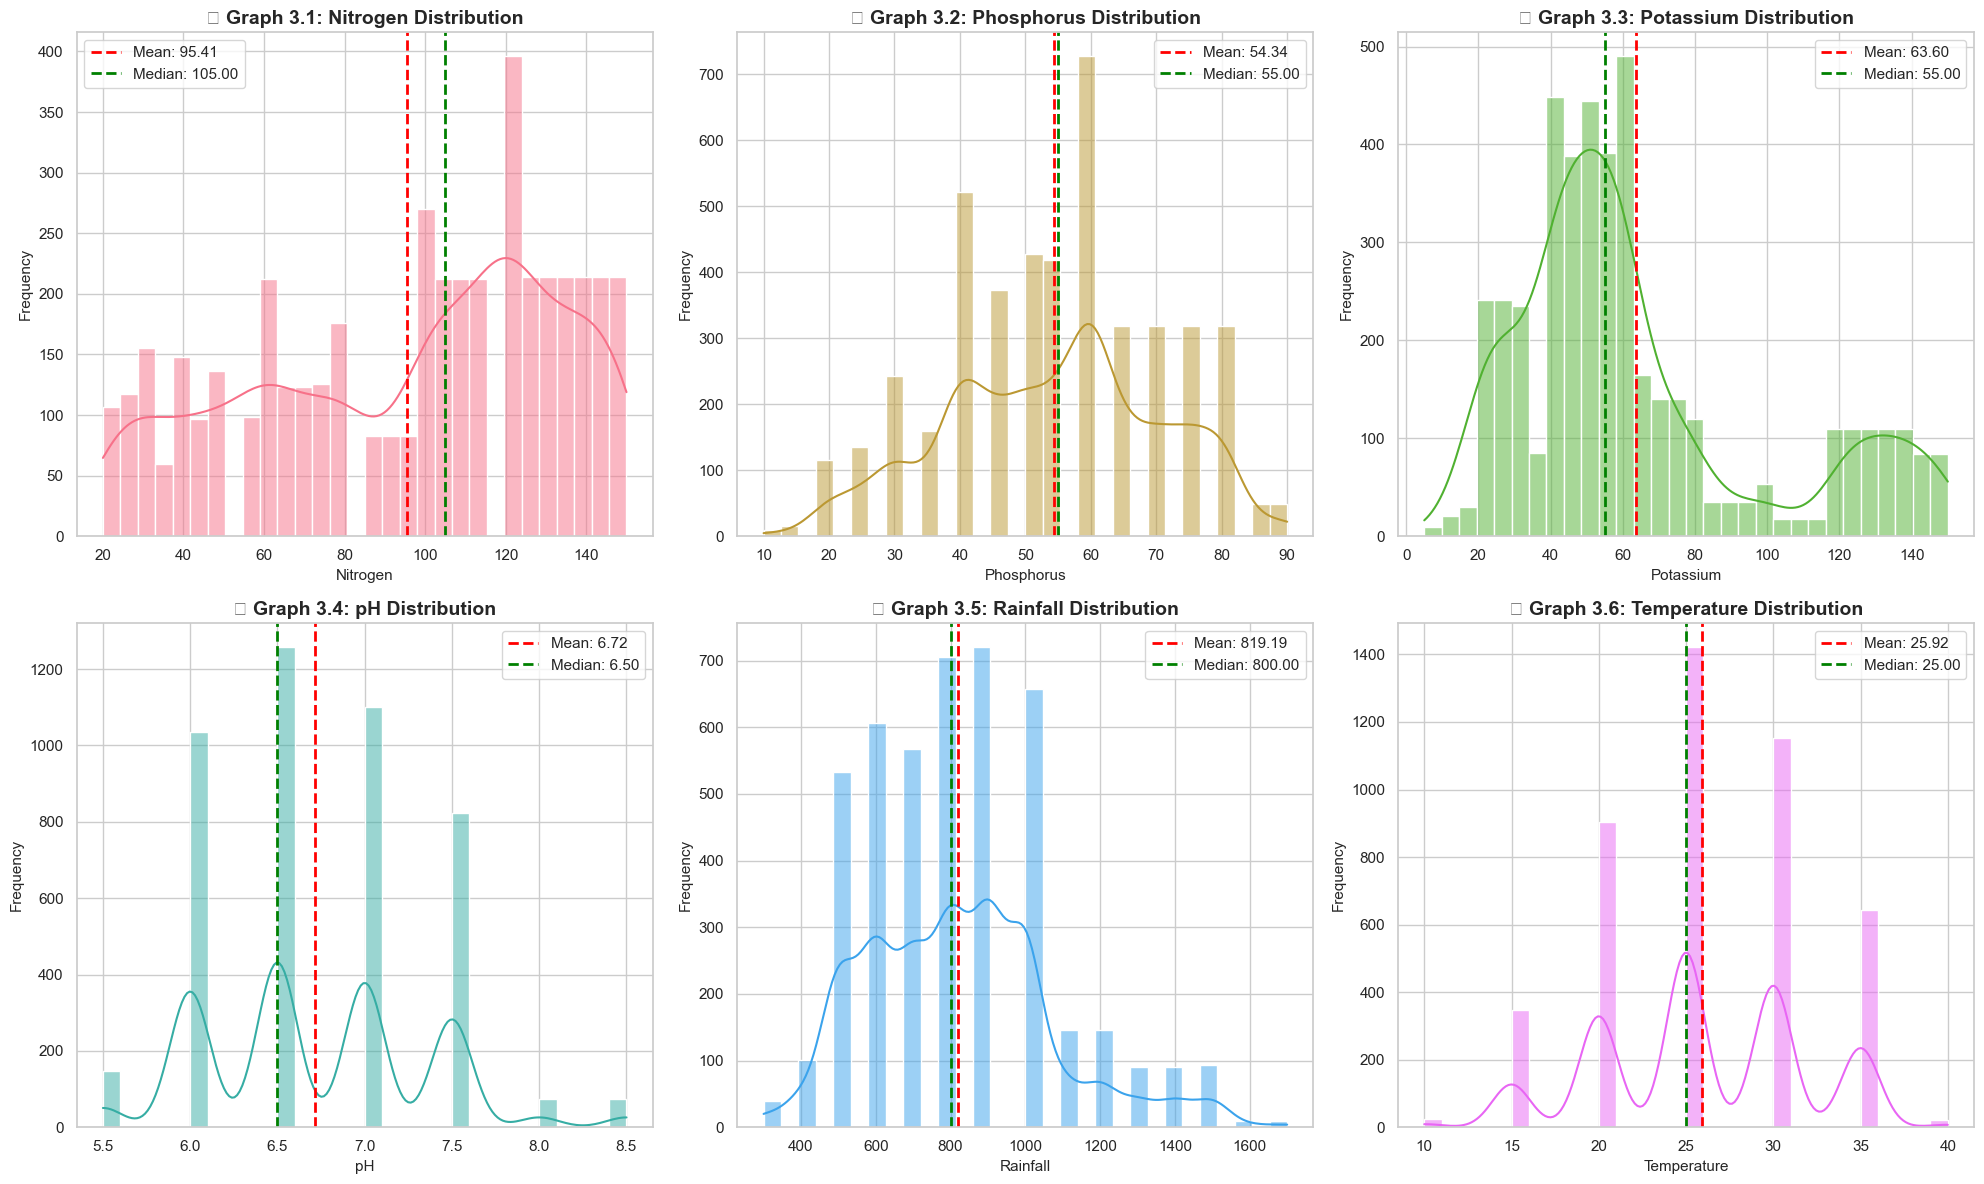

In [17]:
# EDA 3: Distribution of Numerical Features
numerical_cols = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    # Histogram with KDE
    sns.histplot(df_raw[col], kde=True, ax=axes[idx], color=sns.color_palette('husl')[idx], bins=30)
    axes[idx].set_title(f'📈 Graph 3.{idx+1}: {col} Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    
    # Add mean and median lines
    mean_val = df_raw[col].mean()
    median_val = df_raw[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

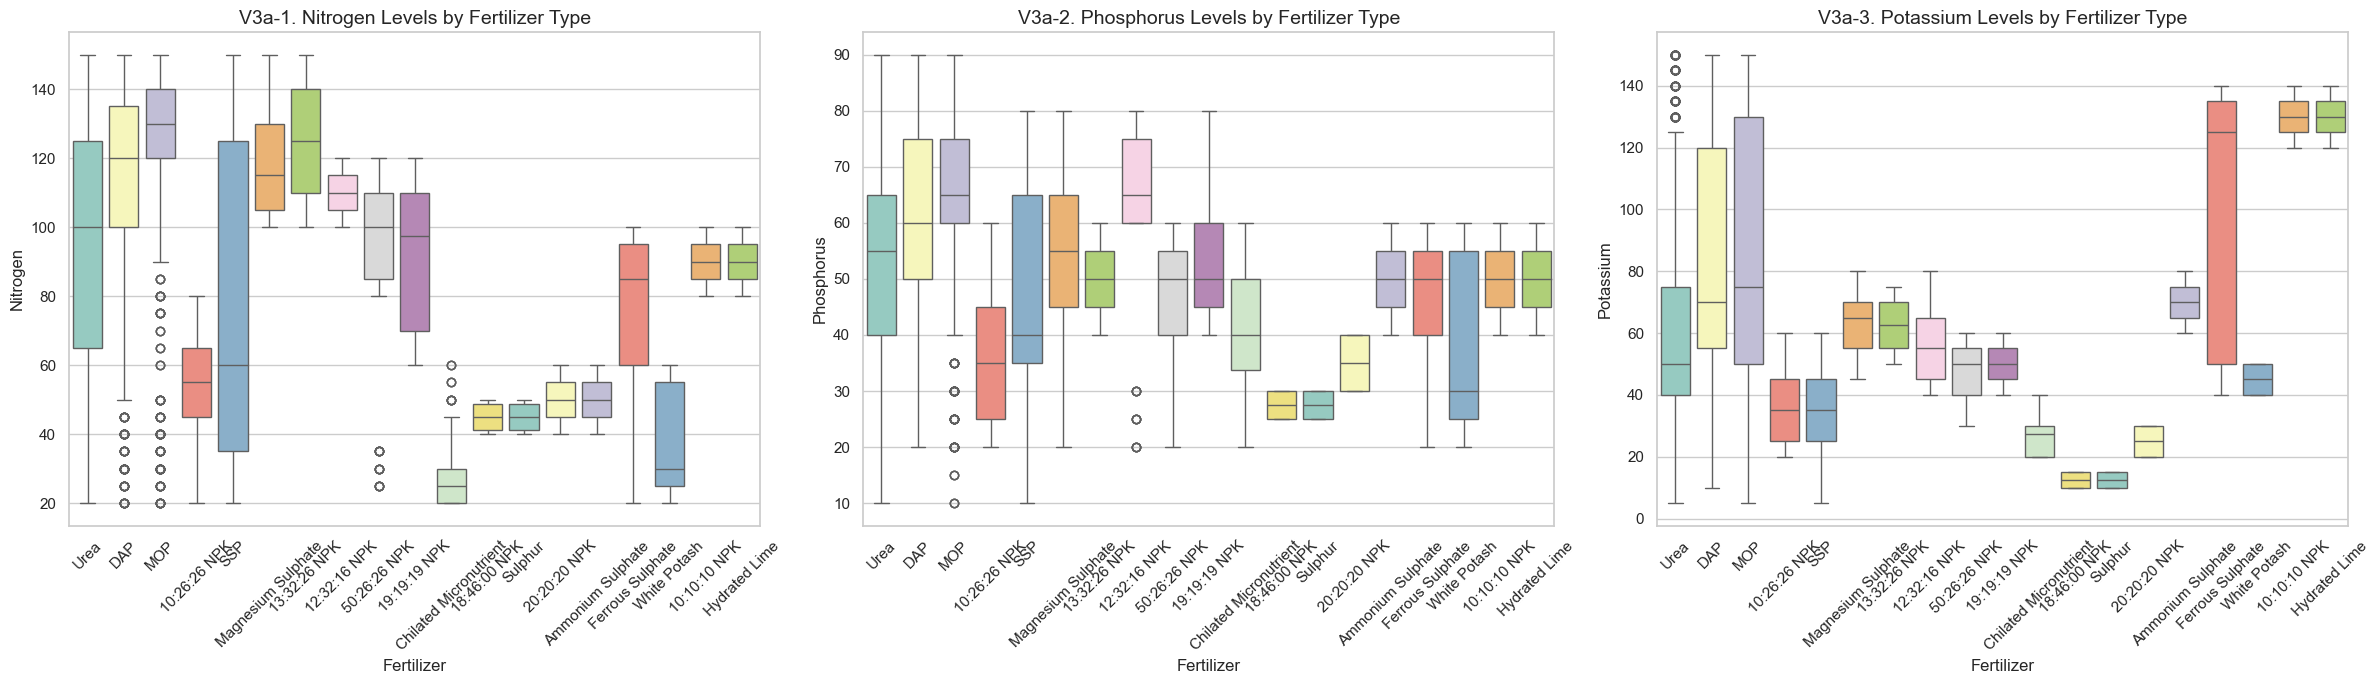

In [18]:
# V3. Bivariate Analysis: Nutrient Dependency on Target
# This is the most crucial plot, showing if a fertilizer type strongly dictates N, P, or K levels.
nutrients = ['Nitrogen', 'Phosphorus', 'Potassium']
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, col in enumerate(nutrients):
    sns.boxplot(x=TARGET_COL, y=col, data=df_raw, ax=axes[i], palette='Set3')
    axes[i].set_title(f'V3a-{i+1}. {col} Levels by Fertilizer Type', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# Analysis Insight: Large separation between boxplots indicates high discriminative power for that nutrient.

In [19]:
print("="*80)
print("🎯 KEY INSIGHTS FROM EDA")
print("="*80)

# Calculate some interesting statistics
print("\n1️⃣ FERTILIZER INSIGHTS:")
fert_counts = df_raw[TARGET_COL].value_counts()
print(f"   • Total Fertilizer Types: {len(fert_counts)}")
print(f"   • Most Used: {fert_counts.index[0]} ({fert_counts.values[0]} samples, {fert_counts.values[0]/len(df_raw)*100:.1f}%)")
print(f"   • Least Used: {fert_counts.index[-1]} ({fert_counts.values[-1]} samples, {fert_counts.values[-1]/len(df_raw)*100:.1f}%)")
print(f"   • Class Imbalance Ratio: {fert_counts.values[0]/fert_counts.values[-1]:.2f}:1")

print("\n2️⃣ CROP INSIGHTS:")
crop_counts = df_raw['Crop'].value_counts()
print(f"   • Total Crop Types: {len(crop_counts)}")
print(f"   • Most Common: {crop_counts.index[0]} ({crop_counts.values[0]} samples)")
print(f"   • Each fertilizer serves avg {len(df_raw)/len(fert_counts):.0f} records")

print("\n3️⃣ NUTRIENT INSIGHTS:")
for nutrient in ['Nitrogen', 'Phosphorus', 'Potassium']:
    print(f"   • {nutrient}: Min={df_raw[nutrient].min()}, Max={df_raw[nutrient].max()}, " + 
          f"Mean={df_raw[nutrient].mean():.2f}, Std={df_raw[nutrient].std():.2f}")

print("\n4️⃣ ENVIRONMENTAL INSIGHTS:")
print(f"   • Temperature Range: {df_raw['Temperature'].min()}°C - {df_raw['Temperature'].max()}°C")
print(f"   • Rainfall Range: {df_raw['Rainfall'].min()}mm - {df_raw['Rainfall'].max()}mm")
print(f"   • pH Range: {df_raw['pH'].min()} - {df_raw['pH'].max()}")

print("\n5️⃣ DATA QUALITY:")
print(f"   • Total Samples: {len(df_raw)}")
print(f"   • Complete Cases: {df_raw.dropna().shape[0]} ({df_raw.dropna().shape[0]/len(df_raw)*100:.1f}%)")
print(f"   • Missing Values: {df_raw.isnull().sum().sum()}")

# Feature variance analysis
print("\n6️⃣ FEATURE VARIANCE (Coefficient of Variation):")
for col in numerical_cols:
    cv = (df_raw[col].std() / df_raw[col].mean()) * 100
    print(f"   • {col}: {cv:.2f}%")

print("\n" + "="*80)
print("✅ EDA COMPLETE! Ready for Model Training...")
print("="*80)

🎯 KEY INSIGHTS FROM EDA

1️⃣ FERTILIZER INSIGHTS:
   • Total Fertilizer Types: 19
   • Most Used: Urea (1364 samples, 30.2%)
   • Least Used: Sulphur (6 samples, 0.1%)
   • Class Imbalance Ratio: 227.33:1

2️⃣ CROP INSIGHTS:
   • Total Crop Types: 16
   • Most Common: Sugarcane (1010 samples)
   • Each fertilizer serves avg 238 records

3️⃣ NUTRIENT INSIGHTS:
   • Nitrogen: Min=20, Max=150, Mean=95.41, Std=38.06
   • Phosphorus: Min=10, Max=90, Mean=54.34, Std=16.55
   • Potassium: Min=5, Max=150, Mean=63.60, Std=35.69

4️⃣ ENVIRONMENTAL INSIGHTS:
   • Temperature Range: 10°C - 40°C
   • Rainfall Range: 300mm - 1700mm
   • pH Range: 5.5 - 8.5

5️⃣ DATA QUALITY:
   • Total Samples: 4513
   • Complete Cases: 4513 (100.0%)
   • Missing Values: 0

6️⃣ FEATURE VARIANCE (Coefficient of Variation):
   • Nitrogen: 39.89%
   • Phosphorus: 30.46%
   • Potassium: 56.12%
   • pH: 9.31%
   • Rainfall: 30.73%
   • Temperature: 22.76%

✅ EDA COMPLETE! Ready for Model Training...


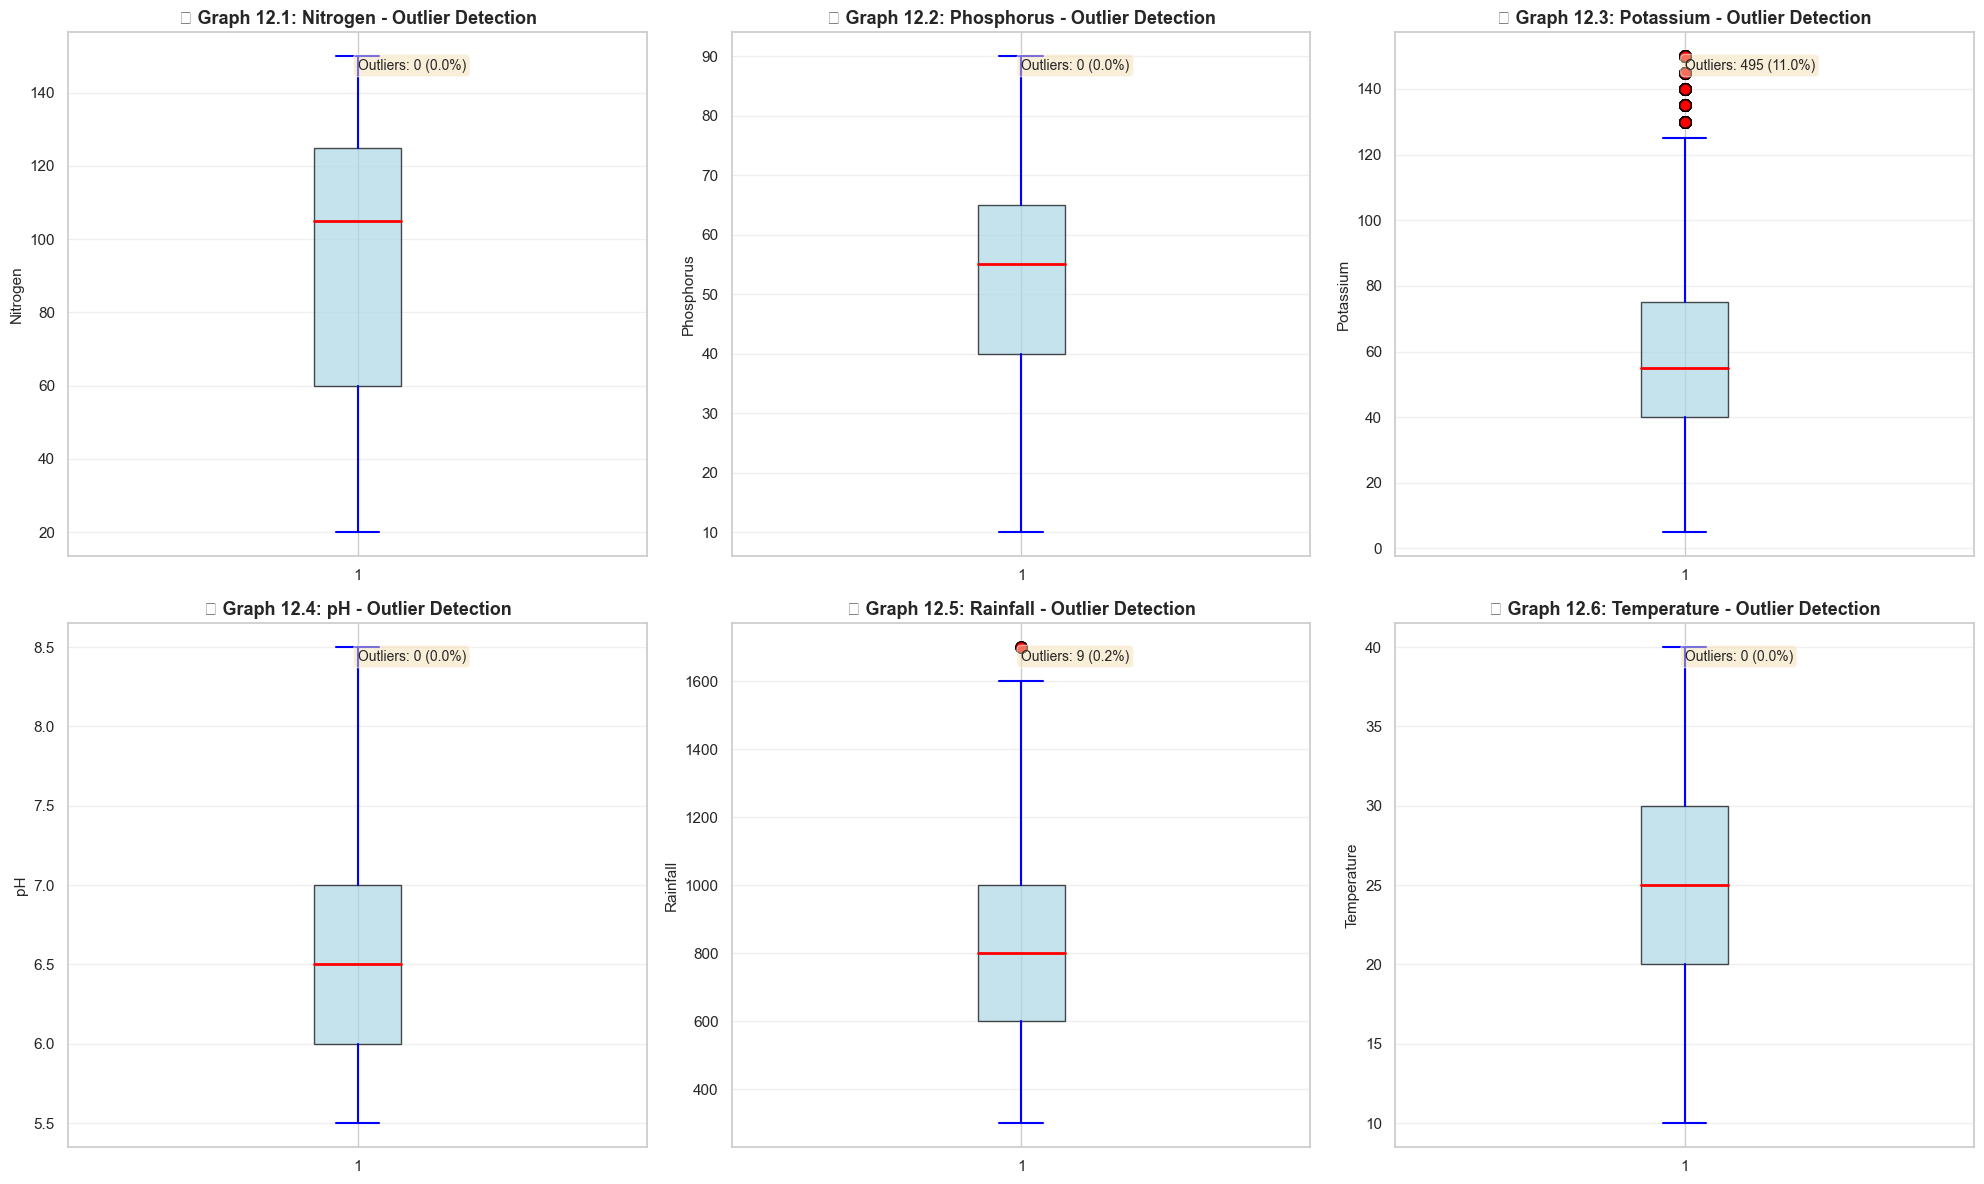


📊 Outlier Summary:
  • Nitrogen: 0 outliers (0.00%)
  • Phosphorus: 0 outliers (0.00%)
  • Potassium: 495 outliers (10.97%)
  • pH: 0 outliers (0.00%)
  • Rainfall: 9 outliers (0.20%)
  • Temperature: 0 outliers (0.00%)


In [20]:
# EDA 12: Outlier Detection and Analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

nutrient_features = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature']

for idx, feature in enumerate(nutrient_features):
    # Box plot with outlier highlighting
    bp = axes[idx].boxplot(df_raw[feature], vert=True, patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           whiskerprops=dict(color='blue', linewidth=1.5),
                           capprops=dict(color='blue', linewidth=1.5),
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=8, alpha=0.5))
    
    axes[idx].set_title(f'📦 Graph 12.{idx+1}: {feature} - Outlier Detection', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Calculate and display statistics
    Q1 = df_raw[feature].quantile(0.25)
    Q3 = df_raw[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw[(df_raw[feature] < lower_bound) | (df_raw[feature] > upper_bound)][feature]
    
    # Add text with outlier count
    axes[idx].text(0.5, 0.95, f'Outliers: {len(outliers)} ({len(outliers)/len(df_raw)*100:.1f}%)', 
                  transform=axes[idx].transAxes, fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n📊 Outlier Summary:")
for feature in nutrient_features:
    Q1 = df_raw[feature].quantile(0.25)
    Q3 = df_raw[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw[(df_raw[feature] < lower_bound) | (df_raw[feature] > upper_bound)]
    print(f"  • {feature}: {len(outliers)} outliers ({len(outliers)/len(df_raw)*100:.2f}%)")

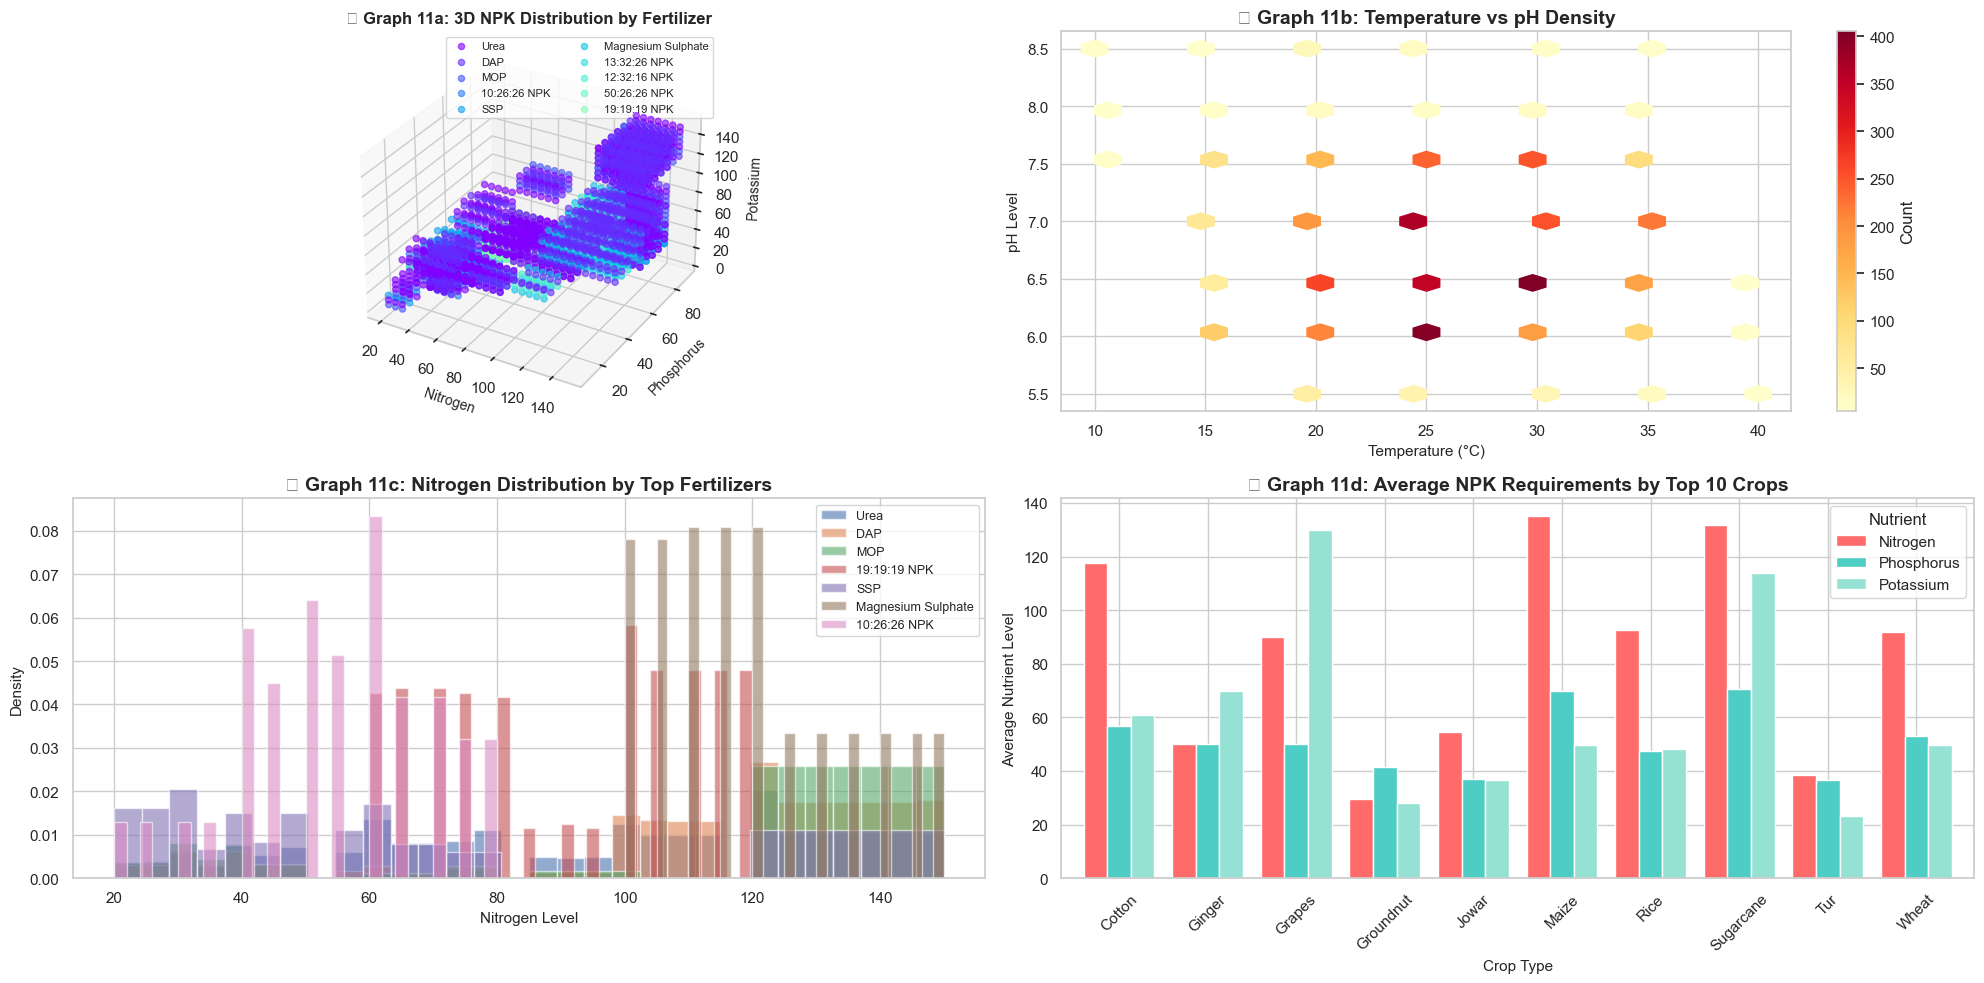

In [21]:
# EDA 11: Advanced Multi-Feature Analysis
fig = plt.figure(figsize=(20, 10))

# 3D Scatter Plot: NPK with Fertilizer Type
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
fertilizer_types = df_raw[TARGET_COL].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(fertilizer_types)))

for fert_type, color in zip(fertilizer_types[:10], colors[:10]):  # Limit to 10 for clarity
    mask = df_raw[TARGET_COL] == fert_type
    ax1.scatter(df_raw[mask]['Nitrogen'], 
               df_raw[mask]['Phosphorus'], 
               df_raw[mask]['Potassium'],
               c=[color], label=fert_type, alpha=0.6, s=20)

ax1.set_xlabel('Nitrogen', fontsize=10)
ax1.set_ylabel('Phosphorus', fontsize=10)
ax1.set_zlabel('Potassium', fontsize=10)
ax1.set_title('🎯 Graph 11a: 3D NPK Distribution by Fertilizer', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=8, ncol=2)

# Hexbin plot: Temperature vs pH
ax2 = fig.add_subplot(2, 2, 2)
hexbin = ax2.hexbin(df_raw['Temperature'], df_raw['pH'], gridsize=25, cmap='YlOrRd', mincnt=1)
ax2.set_title('🔥 Graph 11b: Temperature vs pH Density', fontsize=14, fontweight='bold')
ax2.set_xlabel('Temperature (°C)', fontsize=11)
ax2.set_ylabel('pH Level', fontsize=11)
plt.colorbar(hexbin, ax=ax2, label='Count')

# Ridgeline-style plot for Nitrogen by top fertilizers
ax3 = fig.add_subplot(2, 2, 3)
top_fertilizers = df_raw[TARGET_COL].value_counts().head(7).index
for i, fert in enumerate(top_fertilizers):
    data = df_raw[df_raw[TARGET_COL] == fert]['Nitrogen']
    ax3.hist(data, bins=30, alpha=0.6, label=fert, density=True)
ax3.set_title('📈 Graph 11c: Nitrogen Distribution by Top Fertilizers', fontsize=14, fontweight='bold')
ax3.set_xlabel('Nitrogen Level', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.legend(fontsize=9)

# Average nutrients by top crops
ax4 = fig.add_subplot(2, 2, 4)
top_crops = df_raw['Crop'].value_counts().head(10).index
crop_nutrients = df_raw[df_raw['Crop'].isin(top_crops)].groupby('Crop')[['Nitrogen', 'Phosphorus', 'Potassium']].mean()
crop_nutrients.plot(kind='bar', ax=ax4, width=0.8, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax4.set_title('🌾 Graph 11d: Average NPK Requirements by Top 10 Crops', fontsize=14, fontweight='bold')
ax4.set_xlabel('Crop Type', fontsize=11)
ax4.set_ylabel('Average Nutrient Level', fontsize=11)
ax4.tick_params(axis='x', rotation=45)
ax4.legend(title='Nutrient')

plt.tight_layout()
plt.show()

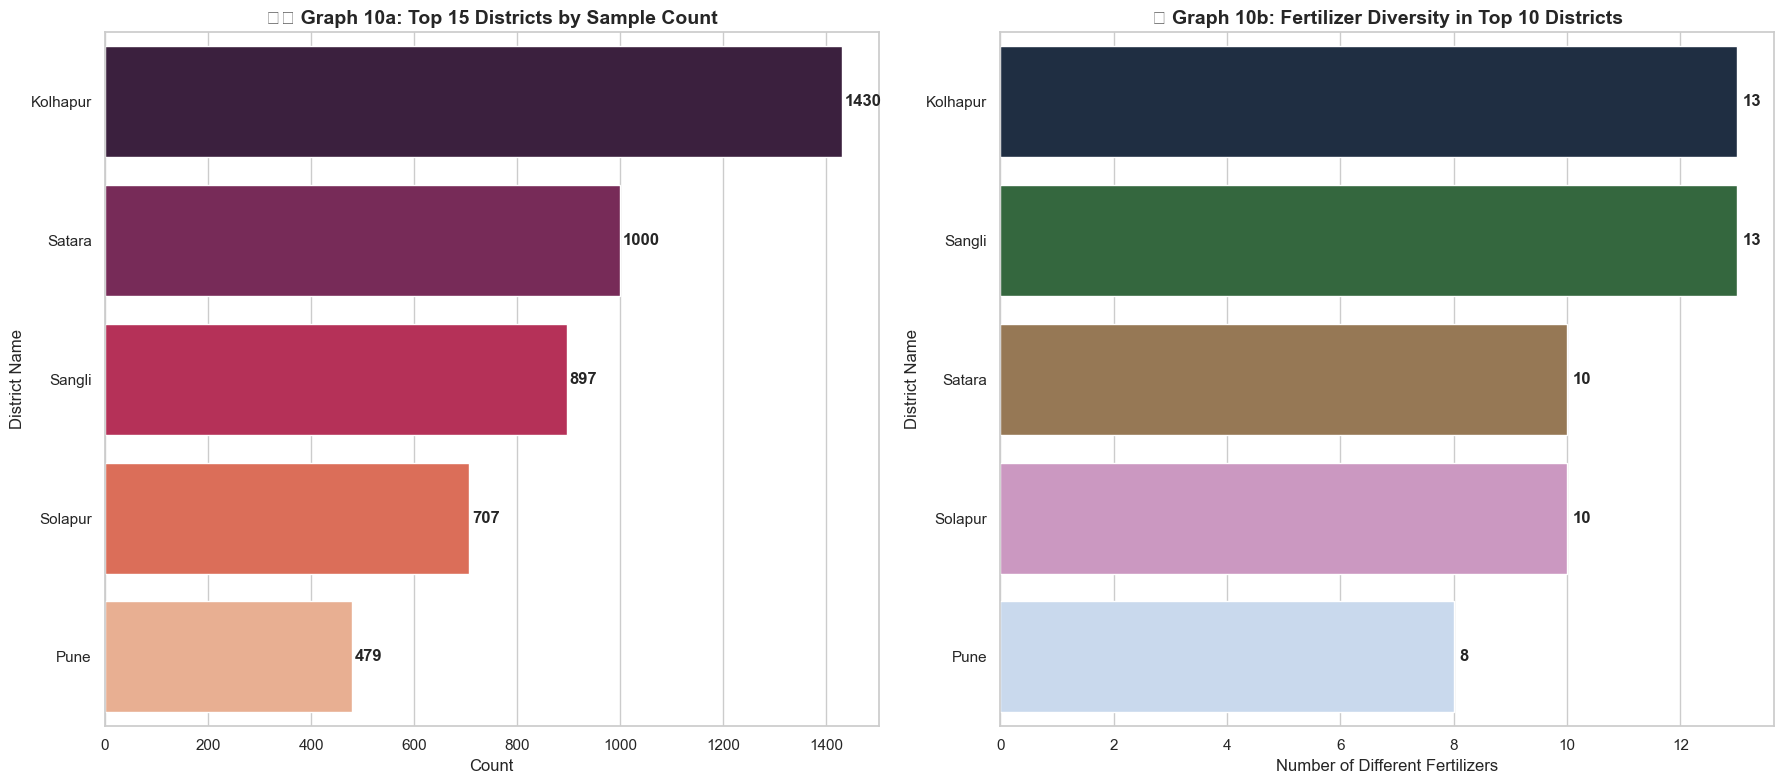


Total Districts: 5
District with most samples: Kolhapur (1430 samples)


In [22]:
# EDA 10: District-wise Analysis
plt.figure(figsize=(18, 8))

# Top districts
plt.subplot(1, 2, 1)
district_counts = df_raw['District_Name'].value_counts().head(15)
sns.barplot(y=district_counts.index, x=district_counts.values, palette='rocket')
plt.title('🗺️ Graph 10a: Top 15 Districts by Sample Count', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('District Name', fontsize=12)
for i, v in enumerate(district_counts.values):
    plt.text(v + 5, i, str(v), va='center', fontweight='bold')

# Fertilizer diversity by district (top 10 districts)
plt.subplot(1, 2, 2)
top_districts = df_raw['District_Name'].value_counts().head(10).index
district_fert_diversity = df_raw[df_raw['District_Name'].isin(top_districts)].groupby('District_Name')[TARGET_COL].nunique().sort_values(ascending=False)
sns.barplot(y=district_fert_diversity.index, x=district_fert_diversity.values, palette='cubehelix')
plt.title('🏆 Graph 10b: Fertilizer Diversity in Top 10 Districts', fontsize=14, fontweight='bold')
plt.xlabel('Number of Different Fertilizers', fontsize=12)
plt.ylabel('District Name', fontsize=12)
for i, v in enumerate(district_fert_diversity.values):
    plt.text(v + 0.1, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal Districts: {df_raw['District_Name'].nunique()}")
print(f"District with most samples: {district_counts.index[0]} ({district_counts.values[0]} samples)")

c:\Users\jaink\AppData\Local\Programs\Python\Python311\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname NPK identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


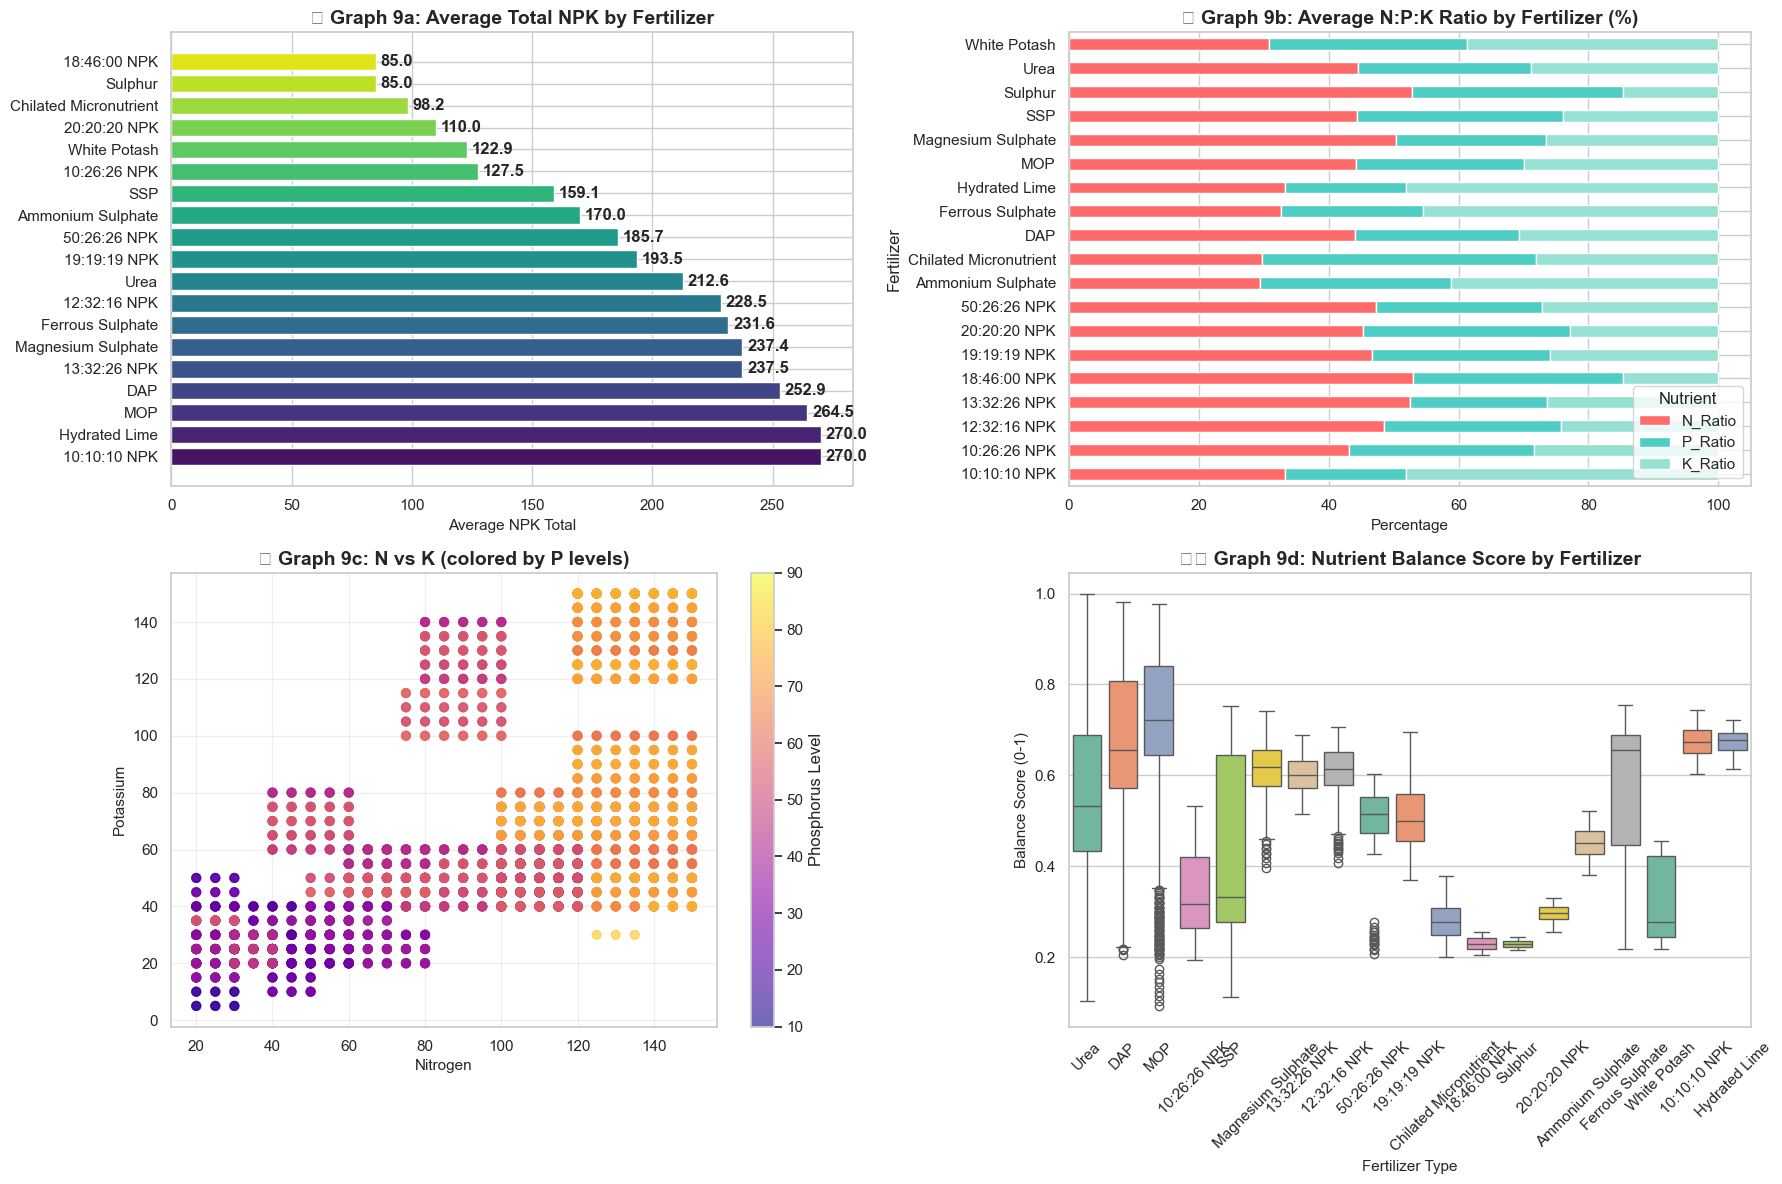

In [23]:
# EDA 9: NPK Ratio Analysis (Advanced Nutrient Analysis)
# Calculate NPK ratio for each sample
df_raw['NPK_Total'] = df_raw['Nitrogen'] + df_raw['Phosphorus'] + df_raw['Potassium']
df_raw['N_Ratio'] = (df_raw['Nitrogen'] / df_raw['NPK_Total']) * 100
df_raw['P_Ratio'] = (df_raw['Phosphorus'] / df_raw['NPK_Total']) * 100
df_raw['K_Ratio'] = (df_raw['Potassium'] / df_raw['NPK_Total']) * 100

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# NPK Total by Fertilizer
npk_by_fert = df_raw.groupby(TARGET_COL)['NPK_Total'].mean().sort_values(ascending=False)
axes[0, 0].barh(npk_by_fert.index, npk_by_fert.values, color=sns.color_palette('viridis', len(npk_by_fert)))
axes[0, 0].set_title('📊 Graph 9a: Average Total NPK by Fertilizer', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Average NPK Total', fontsize=11)
for i, v in enumerate(npk_by_fert.values):
    axes[0, 0].text(v + 2, i, f'{v:.1f}', va='center', fontweight='bold')

# N:P:K Ratio by Fertilizer (Stacked Bar)
ratio_df = df_raw.groupby(TARGET_COL)[['N_Ratio', 'P_Ratio', 'K_Ratio']].mean()
ratio_df.plot(kind='barh', stacked=True, ax=axes[0, 1], color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0, 1].set_title('🔢 Graph 9b: Average N:P:K Ratio by Fertilizer (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Percentage', fontsize=11)
axes[0, 1].legend(title='Nutrient', loc='lower right')

# Nitrogen vs Potassium colored by Phosphorus
scatter = axes[1, 0].scatter(df_raw['Nitrogen'], df_raw['Potassium'], 
                             c=df_raw['Phosphorus'], cmap='plasma', alpha=0.6, s=40)
axes[1, 0].set_title('🎨 Graph 9c: N vs K (colored by P levels)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Nitrogen', fontsize=11)
axes[1, 0].set_ylabel('Potassium', fontsize=11)
plt.colorbar(scatter, ax=axes[1, 0], label='Phosphorus Level')
axes[1, 0].grid(True, alpha=0.3)

# Nutrient Balance Score (Normalized Sum)
df_raw['Nutrient_Balance'] = (df_raw['Nitrogen']/df_raw['Nitrogen'].max() + 
                               df_raw['Phosphorus']/df_raw['Phosphorus'].max() + 
                               df_raw['Potassium']/df_raw['Potassium'].max()) / 3
sns.boxplot(data=df_raw, x=TARGET_COL, y='Nutrient_Balance', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('⚖️ Graph 9d: Nutrient Balance Score by Fertilizer', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_xlabel('Fertilizer Type', fontsize=11)
axes[1, 1].set_ylabel('Balance Score (0-1)', fontsize=11)

plt.tight_layout()
plt.show()

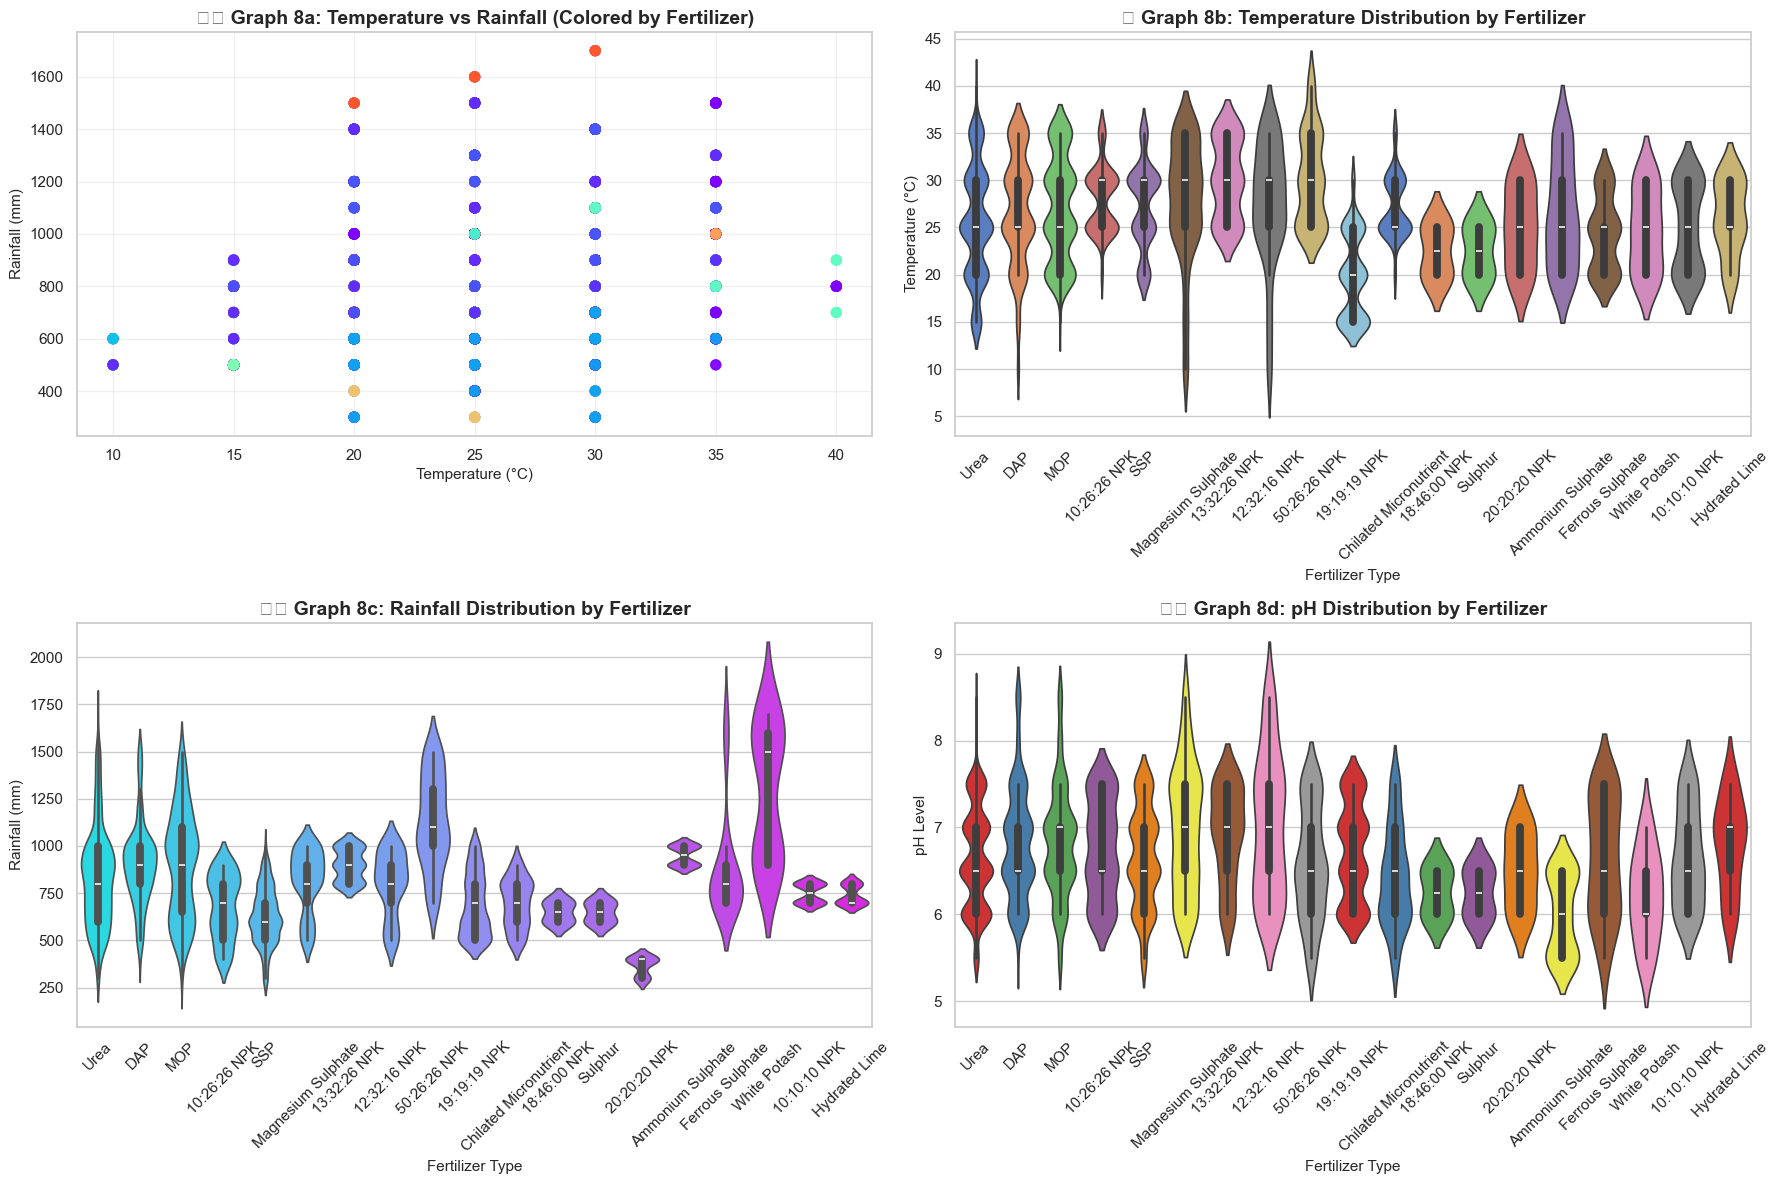

In [24]:
# EDA 8: Environmental Factors (Temperature & Rainfall) Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Temperature vs Rainfall scatter
axes[0, 0].scatter(df_raw['Temperature'], df_raw['Rainfall'], 
                   c=pd.factorize(df_raw[TARGET_COL])[0], cmap='rainbow', alpha=0.6, s=50)
axes[0, 0].set_title('🌡️ Graph 8a: Temperature vs Rainfall (Colored by Fertilizer)', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temperature (°C)', fontsize=11)
axes[0, 0].set_ylabel('Rainfall (mm)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Temperature distribution by Fertilizer
sns.violinplot(data=df_raw, x=TARGET_COL, y='Temperature', ax=axes[0, 1], palette='muted')
axes[0, 1].set_title('🎻 Graph 8b: Temperature Distribution by Fertilizer', 
                     fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_xlabel('Fertilizer Type', fontsize=11)
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)

# Rainfall distribution by Fertilizer
sns.violinplot(data=df_raw, x=TARGET_COL, y='Rainfall', ax=axes[1, 0], palette='cool')
axes[1, 0].set_title('🌧️ Graph 8c: Rainfall Distribution by Fertilizer', 
                     fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xlabel('Fertilizer Type', fontsize=11)
axes[1, 0].set_ylabel('Rainfall (mm)', fontsize=11)

# pH distribution by Fertilizer
sns.violinplot(data=df_raw, x=TARGET_COL, y='pH', ax=axes[1, 1], palette='Set1')
axes[1, 1].set_title('⚗️ Graph 8d: pH Distribution by Fertilizer', 
                     fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_xlabel('Fertilizer Type', fontsize=11)
axes[1, 1].set_ylabel('pH Level', fontsize=11)

plt.tight_layout()
plt.show()

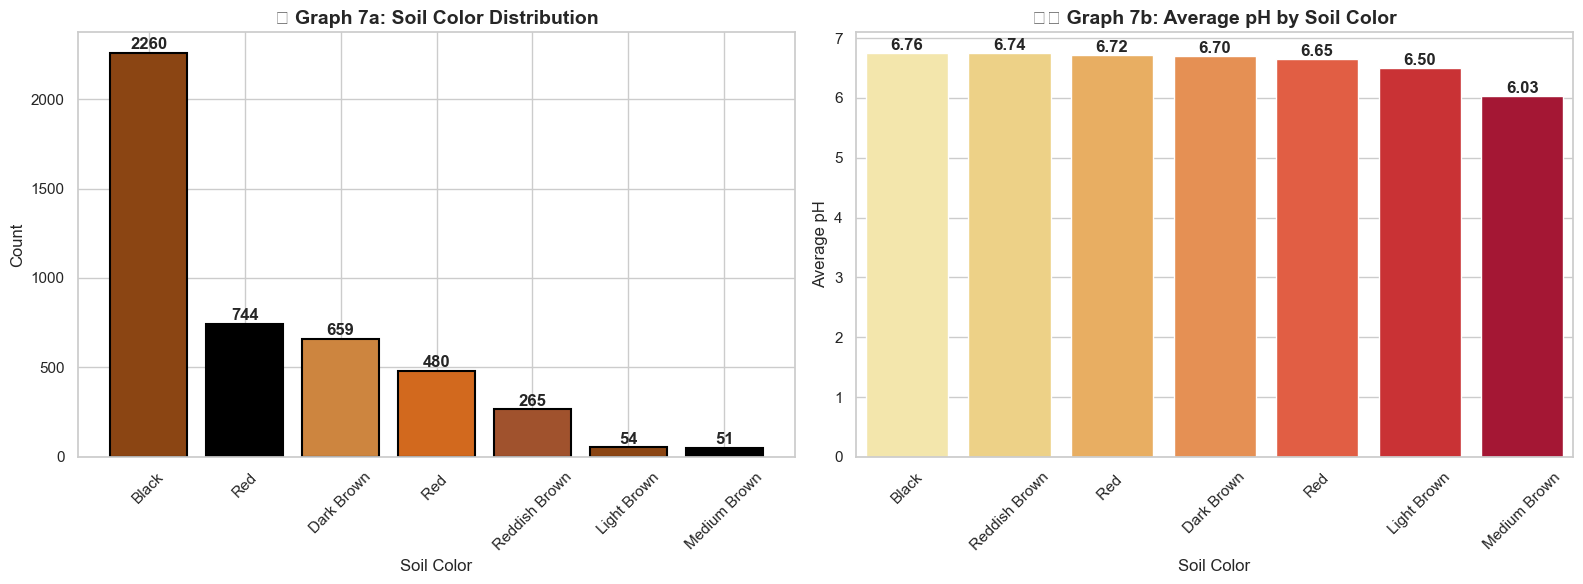

In [25]:
# EDA 7: Soil Color Analysis
plt.figure(figsize=(16, 6))

# Soil color distribution
plt.subplot(1, 2, 1)
soil_counts = df_raw['Soil_color'].value_counts()
colors_palette = ['#8B4513', '#000000', '#CD853F', '#D2691E', '#A0522D'][:len(soil_counts)]
plt.bar(range(len(soil_counts)), soil_counts.values, color=colors_palette, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(soil_counts)), soil_counts.index, rotation=45)
plt.title('🪨 Graph 7a: Soil Color Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Soil Color', fontsize=12)
plt.ylabel('Count', fontsize=12)
for i, v in enumerate(soil_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')

# Average pH by Soil Color
plt.subplot(1, 2, 2)
avg_ph_by_soil = df_raw.groupby('Soil_color')['pH'].mean().sort_values(ascending=False)
sns.barplot(x=avg_ph_by_soil.index, y=avg_ph_by_soil.values, palette='YlOrRd')
plt.title('⚗️ Graph 7b: Average pH by Soil Color', fontsize=14, fontweight='bold')
plt.xlabel('Soil Color', fontsize=12)
plt.ylabel('Average pH', fontsize=12)
plt.xticks(rotation=45)
for i, v in enumerate(avg_ph_by_soil.values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

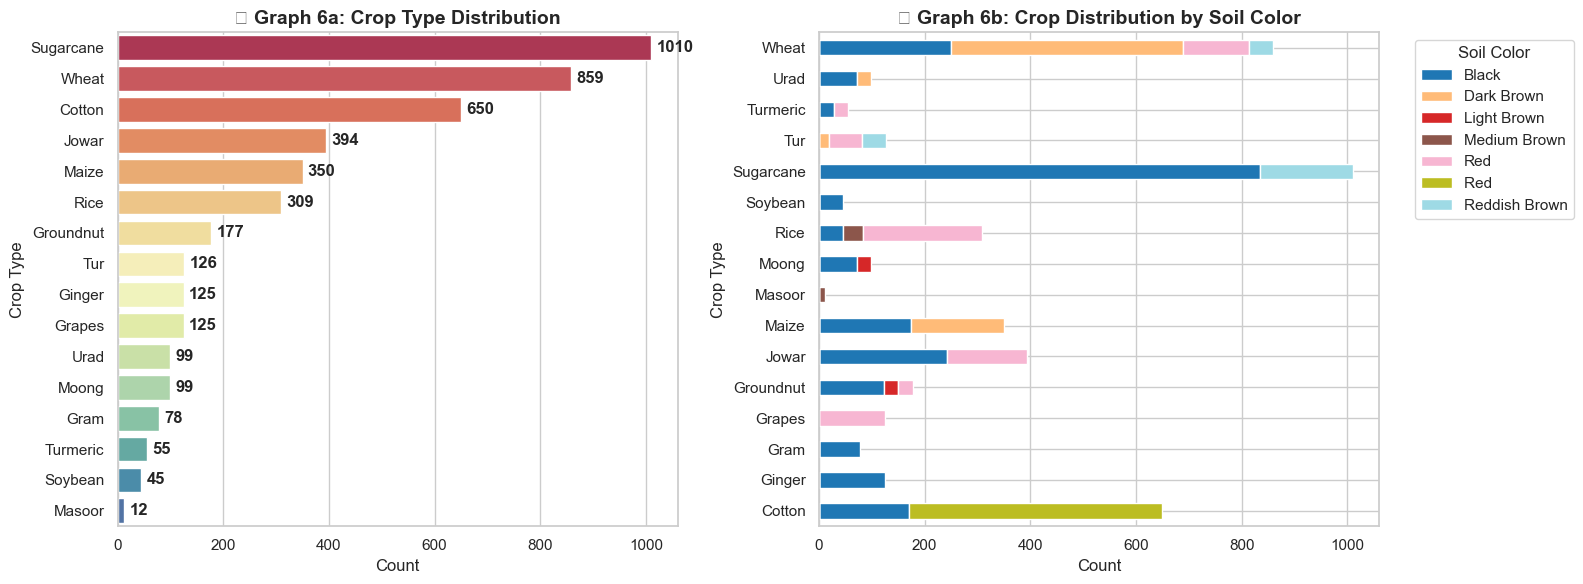


Total Crop Types: 16
Most Grown Crop: Sugarcane (1010 samples)


In [26]:
# EDA 6: Crop Type Distribution and Analysis
plt.figure(figsize=(16, 6))

# Crop distribution
plt.subplot(1, 2, 1)
crop_counts = df_raw['Crop'].value_counts()
sns.barplot(y=crop_counts.index, x=crop_counts.values, palette='Spectral')
plt.title('🌾 Graph 6a: Crop Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Crop Type', fontsize=12)
for i, v in enumerate(crop_counts.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

# Crop vs Soil Color
plt.subplot(1, 2, 2)
crop_soil_cross = pd.crosstab(df_raw['Crop'], df_raw['Soil_color'])
crop_soil_cross.plot(kind='barh', stacked=True, ax=plt.gca(), colormap='tab20')
plt.title('🌍 Graph 6b: Crop Distribution by Soil Color', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Crop Type', fontsize=12)
plt.legend(title='Soil Color', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nTotal Crop Types: {df_raw['Crop'].nunique()}")
print(f"Most Grown Crop: {crop_counts.index[0]} ({crop_counts.values[0]} samples)")

Generating pairplot for NPK nutrients colored by Fertilizer type...
This may take a moment...


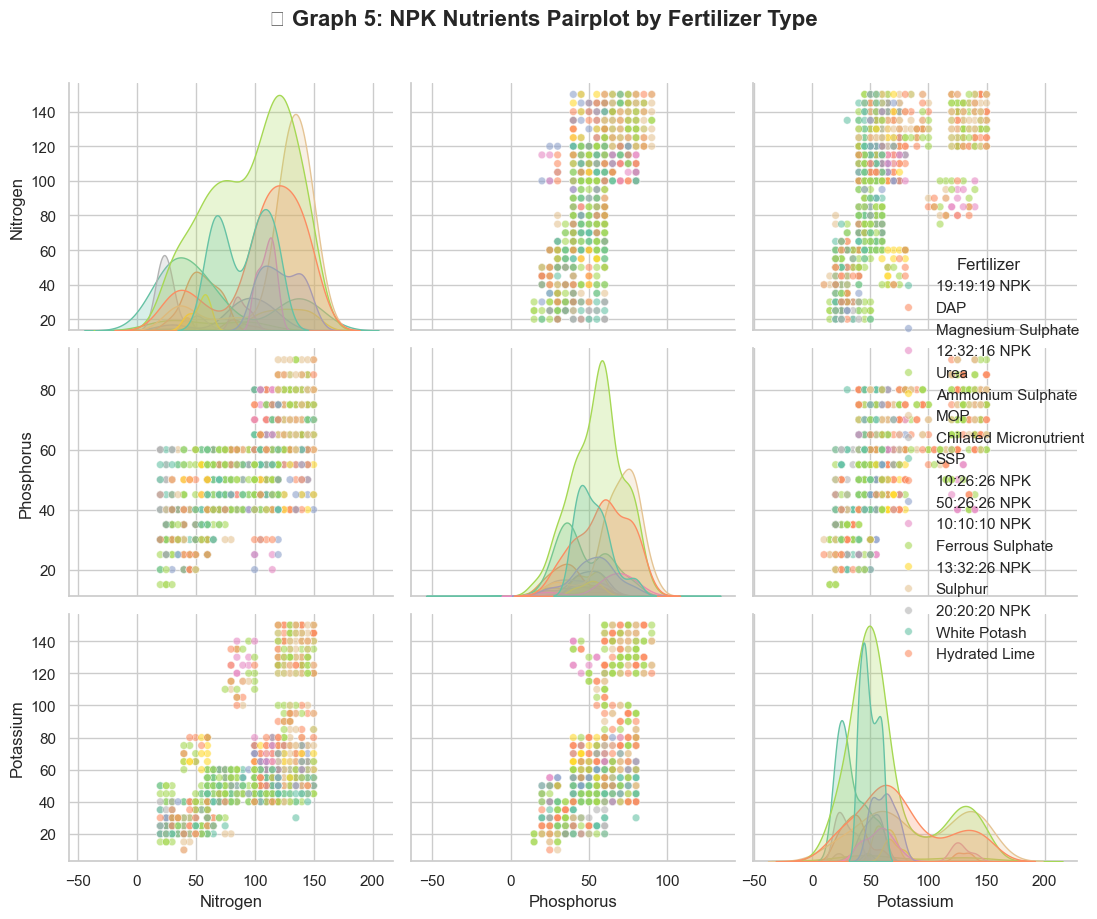

✅ Pairplot complete!


In [27]:
# EDA 5: Pairplot for NPK (Nitrogen, Phosphorus, Potassium) Relationship
print("Generating pairplot for NPK nutrients colored by Fertilizer type...")
print("This may take a moment...")

# Sample data if too large for faster plotting
sample_size = min(1000, len(df_raw))
df_sample = df_raw.sample(n=sample_size, random_state=RANDOM_SEED)

pairplot = sns.pairplot(df_sample[['Nitrogen', 'Phosphorus', 'Potassium', TARGET_COL]], 
                        hue=TARGET_COL, palette='Set2', diag_kind='kde', 
                        plot_kws={'alpha': 0.6, 's': 30}, height=3)
pairplot.fig.suptitle('🎨 Graph 5: NPK Nutrients Pairplot by Fertilizer Type', 
                      y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Pairplot complete!")

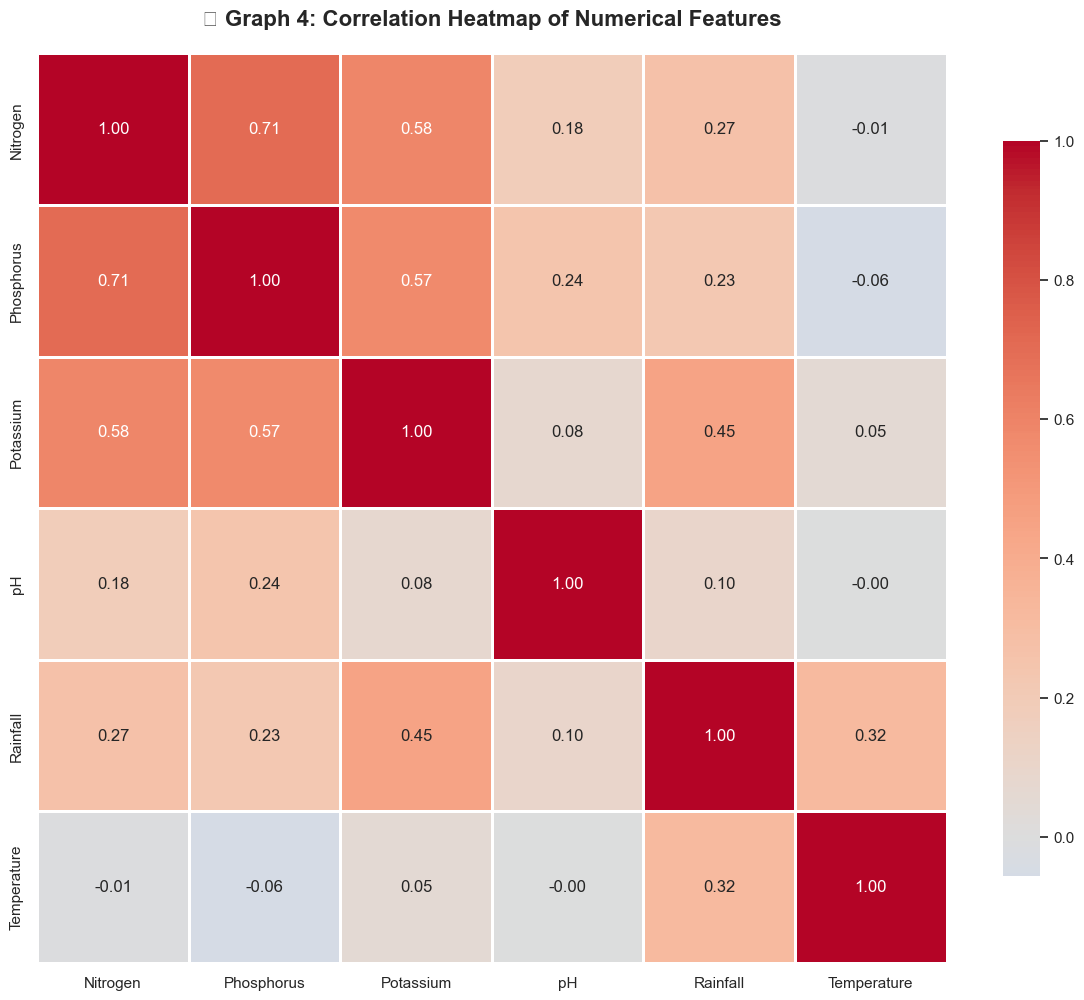


📊 Strong Correlations (|r| > 0.5):
  • Nitrogen <-> Phosphorus: 0.710
  • Nitrogen <-> Potassium: 0.584
  • Phosphorus <-> Potassium: 0.574


In [28]:
# EDA 4: Correlation Heatmap of Numerical Features
plt.figure(figsize=(12, 10))

# Select only numerical columns
numerical_data = df_raw[numerical_cols]
correlation_matrix = numerical_data.corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('🔥 Graph 4: Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Strong Correlations (|r| > 0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f"  • {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

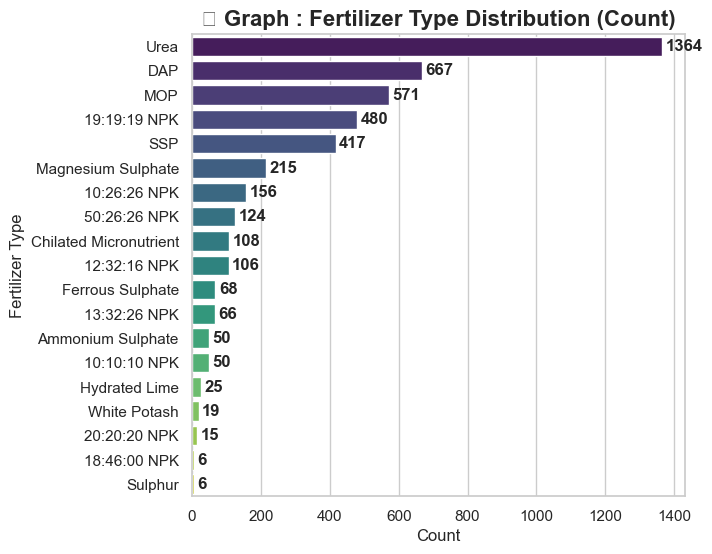

In [31]:
# EDA 2: Target Variable Distribution (Fertilizer Types)
plt.figure(figsize=(14, 6))

# Count plot
plt.subplot(1, 2, 1)
fertilizer_counts = df_raw[TARGET_COL].value_counts()
sns.barplot(x=fertilizer_counts.values, y=fertilizer_counts.index, palette='viridis')
plt.title('📊 Graph : Fertilizer Type Distribution (Count)', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Fertilizer Type', fontsize=12)
for i, v in enumerate(fertilizer_counts.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')


In [32]:
# EDA 1: Dataset Overview and Statistical Summary
print("="*80)
print("DATASET STATISTICAL SUMMARY")
print("="*80)
print("\n📌 Basic Statistics for Numerical Features:")
print(df_raw.describe())

print("\n📌 Data Types and Missing Values:")
print(df_raw.info())

print("\n📌 Missing Values Count:")
print(df_raw.isnull().sum())

print("\n📌 Unique Values in Categorical Columns:")
for col in df_raw.select_dtypes(include='object').columns:
    print(f"{col}: {df_raw[col].nunique()} unique values")
    
print("\n📌 Target Variable Distribution:")
print(df_raw[TARGET_COL].value_counts())

DATASET STATISTICAL SUMMARY

📌 Basic Statistics for Numerical Features:
          Nitrogen   Phosphorus    Potassium           pH     Rainfall  \
count  4513.000000  4513.000000  4513.000000  4513.000000  4513.000000   
mean     95.409927    54.341901    63.595170     6.715267   819.189010   
std      38.060648    16.551991    35.691911     0.625198   251.730813   
min      20.000000    10.000000     5.000000     5.500000   300.000000   
25%      60.000000    40.000000    40.000000     6.000000   600.000000   
50%     105.000000    55.000000    55.000000     6.500000   800.000000   
75%     125.000000    65.000000    75.000000     7.000000  1000.000000   
max     150.000000    90.000000   150.000000     8.500000  1700.000000   

       Temperature    NPK_Total      N_Ratio      P_Ratio      K_Ratio  \
count  4513.000000  4513.000000  4513.000000  4513.000000  4513.000000   
mean     25.915134   213.346998    44.253773    26.908187    28.838040   
std       5.897328    78.461377     8.5

In [40]:
# --- 3. Preprocessing (From train_and_save.py) ---
print("\n--- 3. Preprocessing (Kaggle Notebook Style) ---")
df = df_raw.copy()

# Remove columns deemed unnecessary in the notebook
columns_to_remove = ['District_Name', 'Link']
df = df.drop(columns=columns_to_remove, errors='ignore')

# Handle potential null values (if any)
df = df.dropna()
print(f"After dropping columns and NaNs, shape: {df.shape}")

# --- Ordinal Encoding (Mapping) ---
soil_colors = df['Soil_color'].unique()
crops = df['Crop'].unique()

soil_color_mapping = {val: i for i, val in enumerate(soil_colors)}
crop_mapping = {val: i for i, val in enumerate(crops)}

df['Soil_color'] = df['Soil_color'].map(soil_color_mapping)
df['Crop'] = df['Crop'].map(crop_mapping)

print("Ordinal encoding complete. Features are now all numeric.")

# Target Encoding (Y)
le = LabelEncoder()
df[TARGET_COL] = le.fit_transform(df[TARGET_COL])
y = df[TARGET_COL].values
NUM_CLASSES = len(le.classes_)
TARGET_NAMES = list(le.classes_)
print(f"Target classes: {NUM_CLASSES}")

# Define Features (X)
X_df = df.drop(columns=[TARGET_COL])
X_feature_names = X_df.columns.tolist()

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_df)
N_FEATURES = X.shape[1]

print(f"Feature matrix shape: {X.shape}. Total features: {N_FEATURES}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"Train/Test Split: {X_train.shape} / {X_test.shape}")


--- 3. Preprocessing (Kaggle Notebook Style) ---
After dropping columns and NaNs, shape: (4513, 14)
Ordinal encoding complete. Features are now all numeric.
Target classes: 19
Feature matrix shape: (4513, 13). Total features: 13
Train/Test Split: (3610, 13) / (903, 13)


In [12]:
# --- 4. Baseline Accuracy Check ---
print("\n--- 4. Baseline Accuracy Check ---\n")
# Calculate most frequent class baseline
most_frequent_class = Counter(y_train).most_common(1)[0]
baseline_acc = most_frequent_class[1] / len(y_train)
print(f"Most frequent class: {le.inverse_transform([most_frequent_class[0]])[0]} (Index {most_frequent_class[0]})")
print(f"Baseline (predicting most frequent): {baseline_acc:.4f}")

# Verify with DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_acc = dummy_clf.score(X_test, y_test)
print(f"DummyClassifier Test Accuracy: {dummy_acc:.4f} (Confirms baseline)")


--- 4. Baseline Accuracy Check ---

Most frequent class: Urea (Index 17)
Baseline (predicting most frequent): 0.3022
DummyClassifier Test Accuracy: 0.3023 (Confirms baseline)


In [13]:
# --- 5. Model Optimization (Manual Grid Search) ---
print("\n--- 5. Model Optimization (Using CORRECTED Custom Models) ---")
results = {}
best_score = -1
best_model = None
best_model_name = ""
total_start_time = time.time()

# --- 5a. Custom Random Forest Grid ---
rf_params_grid = {
    'n_trees': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

print("\nStarting Random Forest Grid Search...")
for n_trees in rf_params_grid['n_trees']:
    for max_depth in rf_params_grid['max_depth']:
        model_name = f'RF_T{n_trees}_D{max_depth}'
        print(f"  Testing {model_name}...")
        
        rf_model = RandomForestClassifier(n_trees=n_trees, max_depth=max_depth)
        try:
            start_train = time.time()
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            duration = time.time() - start_train
            print(f"    -> Accuracy: {score:.4f} (Time: {duration:.2f}s)")
            results[model_name] = score

            if score > best_score:
                best_score = score
                best_model = rf_model
                best_model_name = model_name
        except Exception as e:
            print(f"    -> Training failed for {model_name}. Error: {e}")

# --- 5b. Custom SimpleMLP Grid (Aggressive) ---\
mlp_params_grid = {
    'n_hidden': [32, 64, 128],
    'learning_rate': [0.01, 0.05],
    'n_iters': [5000, 10000] 
}

print("\nStarting SimpleMLP Grid Search...")
for n_hidden in mlp_params_grid['n_hidden']:
    for lr in mlp_params_grid['learning_rate']:
        for n_iters in mlp_params_grid['n_iters']:
            model_name = f'MLP_H{n_hidden}_LR{lr}_I{n_iters}'
            print(f"  Testing {model_name}...")
            
            mlp_model = SimpleMLP(
                n_input=N_FEATURES, n_hidden=n_hidden, n_output=NUM_CLASSES, 
                learning_rate=lr, n_iters=n_iters, verbose=False, activation='relu' 
            )
            try:
                start_train = time.time()
                mlp_model.fit(X_train, y_train)
                y_pred = mlp_model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                duration = time.time() - start_train
                print(f"    -> Accuracy: {score:.4f} (Time: {duration:.2f}s)")
                results[model_name] = score

                if score > best_score:
                    best_score = score
                    best_model = mlp_model
                    best_model_name = model_name
            except Exception as e:
                print(f"    -> Training failed for {model_name}. Error: {e}")
            
if best_model is None:
    print("\n❌ Training failed for all critical models.")
else:
    total_end_time = time.time()
    print(f"\nTotal optimization time: {total_end_time - total_start_time:.2f} seconds.")
    print(f"\n✅ Optimization Complete. Best Model: **{best_model_name}** with Accuracy: **{best_score:.4f}**")


--- 5. Model Optimization (Using CORRECTED Custom Models) ---

Starting Random Forest Grid Search...
  Testing RF_T50_D10...
Fitting Random Forest: 50 trees, max_depth=10, min_split=2, features_per_split=2...
  Tree 5/50 fitted.
  Tree 5/50 fitted.
  Tree 10/50 fitted.
  Tree 10/50 fitted.
  Tree 15/50 fitted.
  Tree 15/50 fitted.
  Tree 20/50 fitted.
  Tree 20/50 fitted.
  Tree 25/50 fitted.
  Tree 25/50 fitted.
  Tree 30/50 fitted.
  Tree 30/50 fitted.
  Tree 35/50 fitted.
  Tree 35/50 fitted.
  Tree 40/50 fitted.
  Tree 45/50 fitted.
  Tree 50/50 fitted.
Random Forest fitting complete.
Predicting labels for 903 samples using Random Forest (50 trees)...
    -> Accuracy: 0.6346 (Time: 7.47s)
  Testing RF_T50_D20...
Fitting Random Forest: 50 trees, max_depth=20, min_split=2, features_per_split=2...
  Tree 5/50 fitted.
  Tree 10/50 fitted.
  Tree 15/50 fitted.
  Tree 20/50 fitted.
  Tree 25/50 fitted.
  Tree 30/50 fitted.
  Tree 35/50 fitted.
  Tree 40/50 fitted.
  Tree 45/50 fitted.
 

Predicting labels for 903 samples using Random Forest (100 trees)...

--- Classification Report for Best Model ---
                        precision    recall  f1-score   support

          10:10:10 NPK       0.82      0.90      0.86        10
          10:26:26 NPK       0.71      0.77      0.74        31
          12:32:16 NPK       0.78      0.86      0.82        21
          13:32:26 NPK       1.00      0.92      0.96        13
          18:46:00 NPK       0.50      1.00      0.67         1
          19:19:19 NPK       0.83      0.92      0.87        96
          20:20:20 NPK       1.00      1.00      1.00         3
          50:26:26 NPK       0.96      0.88      0.92        25
     Ammonium Sulphate       0.91      1.00      0.95        10
Chilated Micronutrient       0.74      0.91      0.82        22
                   DAP       0.84      0.82      0.83       134
      Ferrous Sulphate       0.93      0.93      0.93        14
         Hydrated Lime       1.00      0.60      0.7

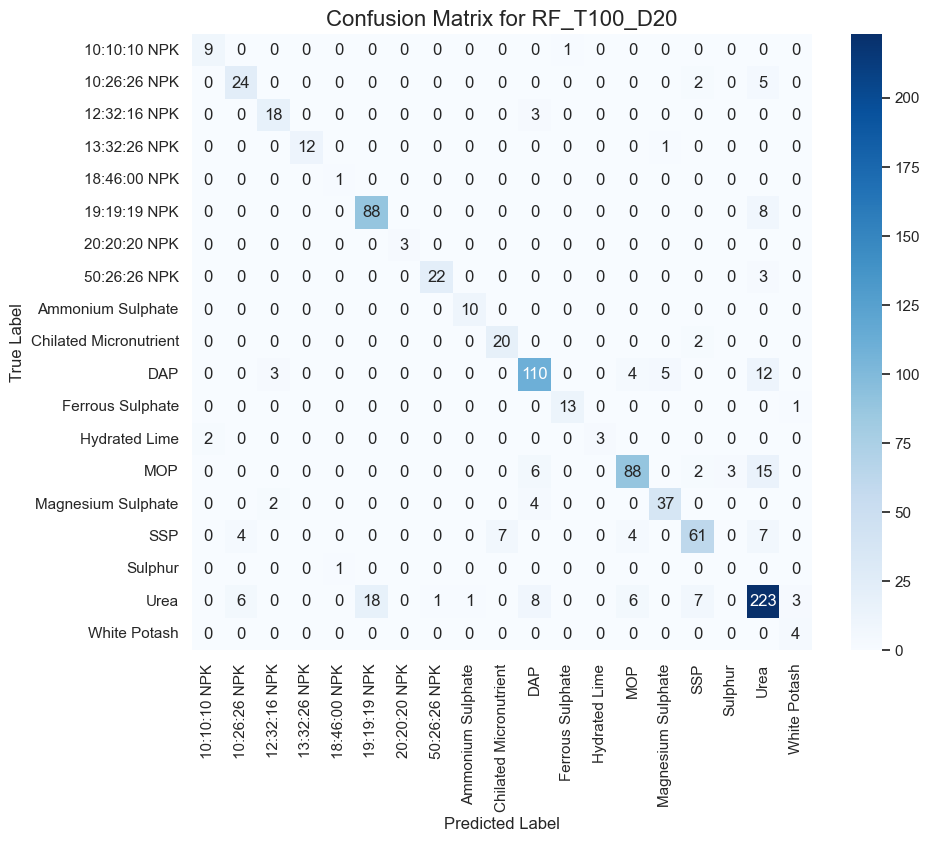

In [14]:
### Final Evaluation of the Best Model
if best_model:
    # Get predictions from the best model
    y_pred_best = best_model.predict(X_test)
    
    print("\n--- Classification Report for Best Model ---")
    print(classification_report(y_test, y_pred_best, target_names=TARGET_NAMES))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
    plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()
else:
    print("❌ Cannot perform final evaluation as no best model was found.")

In [15]:
# --- 6. Saving Model Pipeline ---
print("\n--- 6. Saving Model Pipeline ---")
if best_model:
    pipeline_components = {
        'model': best_model,
        'label_encoder_target': le, 
        'scaler': scaler, 
        'feature_columns': X_feature_names,
        'soil_color_mapping': soil_color_mapping,
        'crop_mapping': crop_mapping,
        'target_names': TARGET_NAMES
    }
    
    try:
        with open(OUTPUT_FILENAME, 'wb') as f:
            pickle.dump(pipeline_components, f)
        print(f"✅ Successfully saved pipeline components to '{OUTPUT_FILENAME}'")
    except Exception as e:
        print(f"❌ ERROR saving pipeline: {e}")
else:
    print("❌ No best model found to save.")


--- 6. Saving Model Pipeline ---
✅ Successfully saved pipeline components to 'fertilizer_recommendation_pipeline.pkl'
✅ Successfully saved pipeline components to 'fertilizer_recommendation_pipeline.pkl'
